In [1]:
import sys; sys.path.insert(0, "..")
from src.models import NeuralNet, BayesianNN
from src.utils import generate_data, neg_log_likelihood, epistemic_uncertainty

In [2]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam
from autograd import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

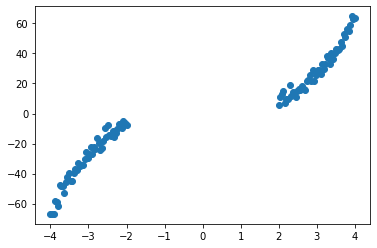

In [3]:
# Generate synthetic data
x, y, x_test, y_test = generate_data(number_of_points=50, noise_variance=9)

plt.scatter(x, y)
plt.show()

In [4]:
# Set up architecture for Bayesia neural network

activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

width = [50] # Use single layer to save computation time (same as the paper)
hidden_layers = len(width)
input_dim = 1
output_dim = 1

architecture = {
    'width': width,
    'hidden_layers': hidden_layers,
    'input_dim': input_dim,
    'output_dim': output_dim,
    'activation_fn_type': 'relu',
    'activation_fn_params': 'rate=1',
    'activation_fn': activation_fn,
}

params = {
    'step_size': 5e-2,
    'max_iteration': 3000,
    'random_restarts': 1,
    'reg_param':1e-5
}


random = np.random.RandomState(207) #set random state to make the experiments replicable

# Initialize a Bayesian neural network
bnn = BayesianNN(architecture, random=random)

#fit Bayesian neural network to obtain MLE/MAP solution for weights
bnn.fit(x, y, params)

Iteration 0 loss 2410.301570610374; gradient mag: 1550.964056098319
Iteration 100 loss 64.24568223821262; gradient mag: 18.519773779512082
Iteration 200 loss 11.218378219906327; gradient mag: 2.9452478223669307
Iteration 300 loss 9.333012301746438; gradient mag: 2.2551456891855346
Iteration 400 loss 8.773294622775593; gradient mag: 1.326670323666498
Iteration 500 loss 8.636553626544314; gradient mag: 5.520479319478406
Iteration 600 loss 8.465974502162952; gradient mag: 1.2290977938189391
Iteration 700 loss 8.338198811642746; gradient mag: 0.7405981768560939
Iteration 800 loss 8.270036610785498; gradient mag: 2.5831194132406234
Iteration 900 loss 8.203917589515106; gradient mag: 0.9779103588571821
Iteration 1000 loss 8.1788539288262; gradient mag: 5.226953403855515
Iteration 1100 loss 8.13603575144029; gradient mag: 1.6690010303209535
Iteration 1200 loss 7.944470020974289; gradient mag: 3.963488765307481
Iteration 1300 loss 7.8053861409092535; gradient mag: 3.1514712933646156
Iteration 

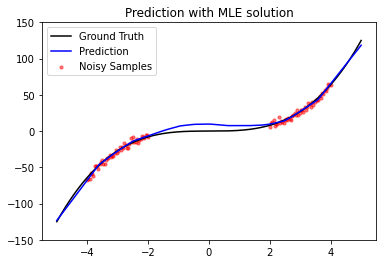

In [5]:
# visualize prediction on test data with MLE/MAP weights
y_test_pred = bnn.forward(bnn.weights, x_test)

plt.scatter(x,y, color='red', s = 10, alpha = 0.5, label="Noisy Samples")
plt.plot(x_test.flatten(), y_test.flatten(), color='black', label="Ground Truth")
plt.plot(x_test.flatten(), y_test_pred.flatten(), color='blue', label="Prediction")
plt.ylim([-150, 150])
plt.title("Prediction with MLE solution")
plt.legend()
plt.show()

In [6]:
# Set up HMC parameters and perform sampling

HMC_param = {'step_size': 5e-3, 
             'leapfrog_steps': 60, 
             'total_samples': 5000, 
             'burn_in': 0.1, 
             'thinning_factor': 2}

noise_sd = 3.
prior_sd = 5.

bnn.sample_HMC(x, y, prior_sd = prior_sd, noise_sd = noise_sd, HMC_param = HMC_param)

print('Final accept =', bnn.accept)

Iteration 0, accept = 0.0


/Users/shihyitseng/anaconda3/envs/am207/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Iteration 100, accept = 0.9499999999990499
Iteration 200, accept = 0.9299999999995351
Iteration 300, accept = 0.9099999999996967
Iteration 400, accept = 0.9024999999997744
Iteration 500, accept = 0.8759999999998248
Iteration 600, accept = 0.8683333333331885
Iteration 700, accept = 0.8671428571427332
Iteration 800, accept = 0.8562499999998929
Iteration 900, accept = 0.8522222222221275
Iteration 1000, accept = 0.8499999999999149
Iteration 1100, accept = 0.8445454545453778
Iteration 1200, accept = 0.843333333333263
Iteration 1300, accept = 0.8430769230768582
Iteration 1400, accept = 0.8414285714285114
Iteration 1500, accept = 0.839999999999944
Iteration 1600, accept = 0.8368749999999476
Iteration 1700, accept = 0.834705882352892
Iteration 1800, accept = 0.834444444444398
Iteration 1900, accept = 0.8336842105262718
Iteration 2000, accept = 0.8354999999999582
Iteration 2100, accept = 0.8319047619047223
Iteration 2200, accept = 0.8272727272726896
Iteration 2300, accept = 0.8252173913043119
I

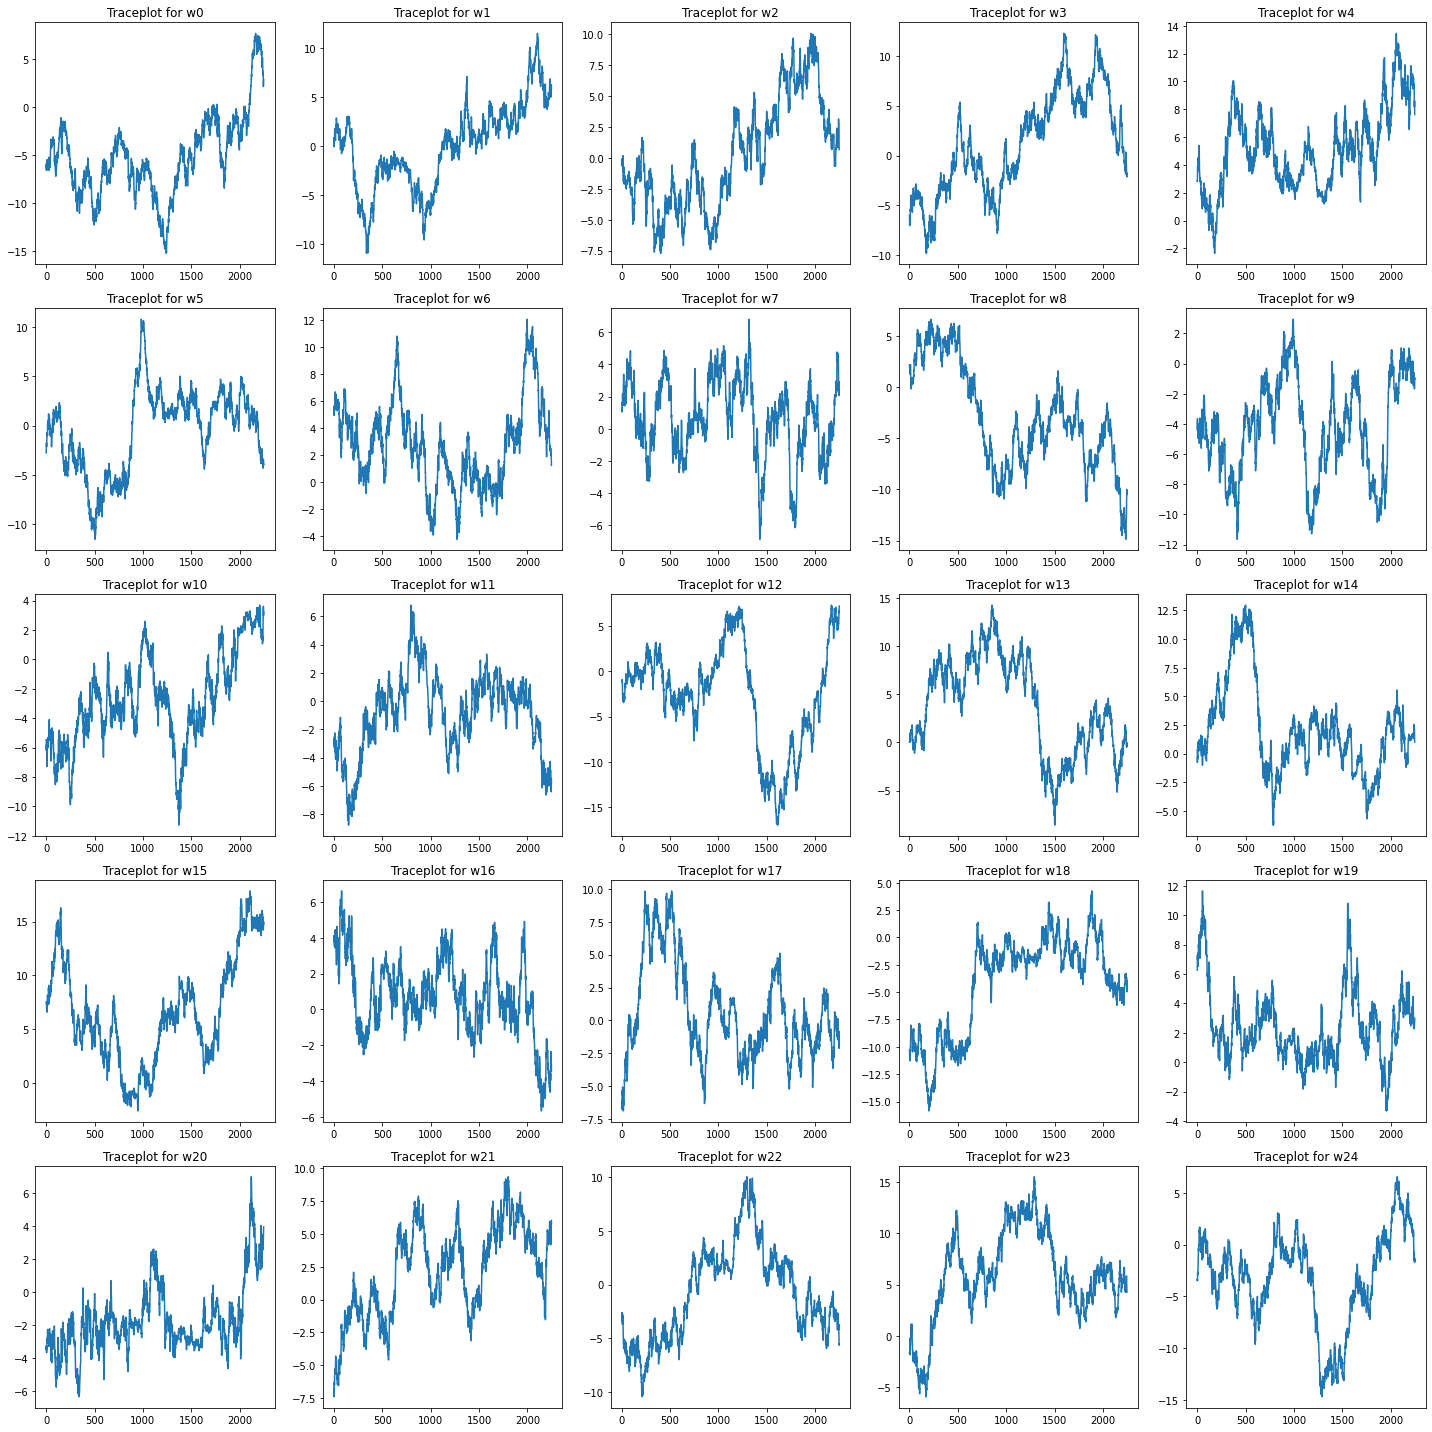

In [7]:
# Visualize some traceplots for diagnostics
fig, ax = plt.subplots(5,5,figsize = (20,20))
for i in range(25):
    ax[i//5,i%5].plot(bnn.thinned_trace[:,i])
    ax[i//5,i%5].set_title('Traceplot for w{}'.format(i))
plt.tight_layout()

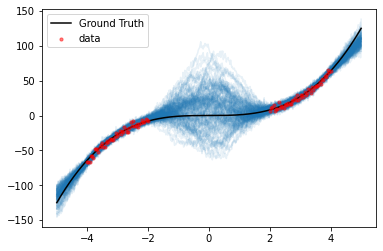

In [8]:
# Visualize posterior predictive
posterior_predictive = bnn.get_posterior_predictive(x_test, add_noise = True)

plt.plot(x_test.T, posterior_predictive[np.random.choice(posterior_predictive.shape[0], size = 100, replace = False),:].T,color='tab:blue', alpha=0.1)
plt.scatter(x.flatten(), y.flatten(), s=10, zorder = 1000, color='r', alpha=0.5,label='data')
plt.plot(x_test.flatten(), y_test.flatten(), color='black', label="Ground Truth")
plt.legend(loc='best')
plt.show()

In [9]:
# Calulating percentiles
pp_upper = np.percentile(posterior_predictive, 97.5, axis=0)
pp_lower = np.percentile(posterior_predictive, 2.5, axis=0)
pp_upper2 = np.percentile(posterior_predictive, 84, axis=0)
pp_lower2 = np.percentile(posterior_predictive, 16, axis=0)
pp_upper3 = np.percentile(posterior_predictive, 99.85, axis=0)
pp_lower3 = np.percentile(posterior_predictive, 0.15, axis=0)
pp_mean = np.mean(posterior_predictive, axis=0)

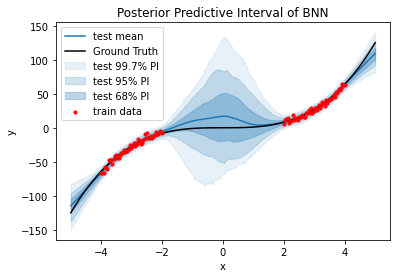

In [10]:
# Visualizing posterior predictive interval 
plt.fill_between(x_test.flatten(), pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1, label = 'test 99.7% PI')
plt.fill_between(x_test.flatten(), pp_upper, pp_lower, color = 'tab:blue', alpha = 0.2, label = 'test 95% PI')
plt.fill_between(x_test.flatten(), pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label = 'test 68% PI')
plt.plot(x_test.flatten(), pp_mean, color = 'tab:blue', alpha = 1, label = 'test mean')
plt.plot(x_test.flatten(), y_test.flatten(), color='black', label="Ground Truth")
plt.scatter(x.flatten(), y.flatten(), s=10, zorder = 1000, color = "red", label = "train data", alpha = 0.9)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')

plt.title("Posterior Predictive Interval of BNN")
plt.show()

In [11]:
# Compute neg_log_likelihood and epistemic uncertainty on training data
posterior_predictive_noise = bnn.get_posterior_predictive(x, add_noise = True)
posterior_predictive = bnn.get_posterior_predictive(x, add_noise = False)

print('Negative log likelihood on training data =', neg_log_likelihood(posterior_predictive_noise, y, noise_sd**2))
print('Epistemic uncertainty on training data = ', epistemic_uncertainty(posterior_predictive))

Negative log likelihood on training data = 4.987619155252633
Epistemic uncertainty on training data =  0.9793802346989117


In [12]:
# Compute neg_log_likelihood and epistemic uncertainty on test data (gap vs. non-gap)
gap_idx = np.logical_and(x_test > -2, x_test < 2)
x_test_gap = x_test[gap_idx].reshape(1,-1)
y_test_gap = y_test[gap_idx].reshape(1,-1)

non_gap_idx = np.logical_or(np.logical_and(x_test > -4, x_test < -2),np.logical_and(x_test > 2, x_test < 4))
x_test_non_gap = x_test[non_gap_idx].reshape(1,-1)
y_test_non_gap = y_test[non_gap_idx].reshape(1,-1)

posterior_predictive_gap = bnn.get_posterior_predictive(x_test_gap, add_noise = False)
posterior_predictive_non_gap = bnn.get_posterior_predictive(x_test_non_gap, add_noise = False)
posterior_predictive_gap_noise = bnn.get_posterior_predictive(x_test_gap, add_noise = True)
posterior_predictive_non_gap_noise = bnn.get_posterior_predictive(x_test_non_gap, add_noise = True)

print('Negative log likelihood on test data (gap) =', neg_log_likelihood(posterior_predictive_gap_noise, y_test_gap, noise_sd**2))
print('Epistemic uncertainty on test data (gap) = ', epistemic_uncertainty(posterior_predictive_gap))

print('Negative log likelihood on test data (non-gap) =', neg_log_likelihood(posterior_predictive_non_gap_noise, y_test_non_gap, noise_sd**2))
print('Epistemic uncertainty on test data (non-gap) = ', epistemic_uncertainty(posterior_predictive_non_gap))

Negative log likelihood on test data (gap) = 95.96611428078265
Epistemic uncertainty on test data (gap) =  18.310940596219986
Negative log likelihood on test data (non-gap) = 3.7831109132734784
Epistemic uncertainty on test data (non-gap) =  0.9626003697840338
